<div style="padding:1em;background-color:#61223B;color:white;text-align:center;">
    <h1>Kalman Filters and Sensor Fusion</h1>
   <h3>Assignment 3: Sensor Fusion</h3>
</div>

The purpose of this assignment is to implement algorithms that combine measurements from multiple sensors at varying frequencies to achieve high-performanc estimation. The assignment aims to build up the concepts of how using multiple sensors increases estimation accuracy The assignment is structured as follows:
- Implement a linear sensor fusion algorithm
- Implement a 2D, non-linear sensor fusion algorithm



In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat

from Gaussian import Gaussian
from StraightLineCar import StraightLineCar
from utils3 import *

<h3 style="margin-bottom:1em;border-bottom:solid 3px #61223B">1. Linear Sensor Fusion</h3>

To familarise yourself with the sensor fusion principles, we use a 1D example of a car travelling in a straight line.
The car has position and speed as states and the input is an acceleration.

The state update equations are given by,
$$ \begin{bmatrix}
x_k \\
v_k \\ 
\end{bmatrix}=\begin{bmatrix}
1,~ dT \\
0,~~ 1 \\
\end{bmatrix} \begin{bmatrix}
x_{k-1} \\
v_{k-1} \\ 
\end{bmatrix} + \begin{bmatrix}
0 \\
dT \\ 
\end{bmatrix} u  +  \mathbf{w}_{k}$$ 
where $x$ is the position, $v$ is the speed and $dT$ is the timestep.


The code is given to you that uses a Linear Kalman Filter (LKF) to estimate the state of the vehicle based on the inputs.
You can first study and run the code.

You should implement code to use a Linear Kalman Filter (LKF) to estimate the state of the car based only on the inputs. You can use your answers from the first two assignments.
A driver function is provided for you to test your code.

In [16]:
simulation_time = 10 # seconds
f_control = 20 # seconds
f_imu = 10 # seconds
f_gps = 0.5 # seconds

init_state = np.array([[0], [0]])
init_belief = Gaussian(init_state, np.diag([1**2, 0.5**2]))

inputs = np.sin(np.linspace(0, 10, simulation_time * f_control))  + 0.02

def simulate_car(car, inputs, estimator):
    for t in range(simulation_time * f_control):
        car.move(inputs[t])
        estimator.control_update(inputs[t])

        measurement = car.measure()
        estimator.measurement_update(measurement)

In [17]:

class LinearControlEstimator:
    def __init__(self, init_belief, A, B, Q):
        self.beliefs = [init_belief]
        self.A = A
        self.B = B
        self.Q = Q

    def control_update(self, u):
        mean = self.beliefs[-1].get_mean()
        cov = self.beliefs[-1].get_covariance()
        mean_ = self.A.dot(mean) + self.B.dot(u)
        cov_ = self.A.dot(cov).dot(self.A.T) + self.Q
        prior_belief = Gaussian(mean_, cov_)
        self.beliefs.append(prior_belief)

    def measurement_update(self, y):
        pass

    def get_estimated_states(self):
        states = [belief.get_mean() for belief in self.beliefs]
        return np.array(states)[:, :, 0]
    
    def get_estimated_covariances(self):
        covariances = [belief.get_covariance() for belief in self.beliefs]
        return np.array(covariances)
    

Mean Error (No Sensor): 2.970


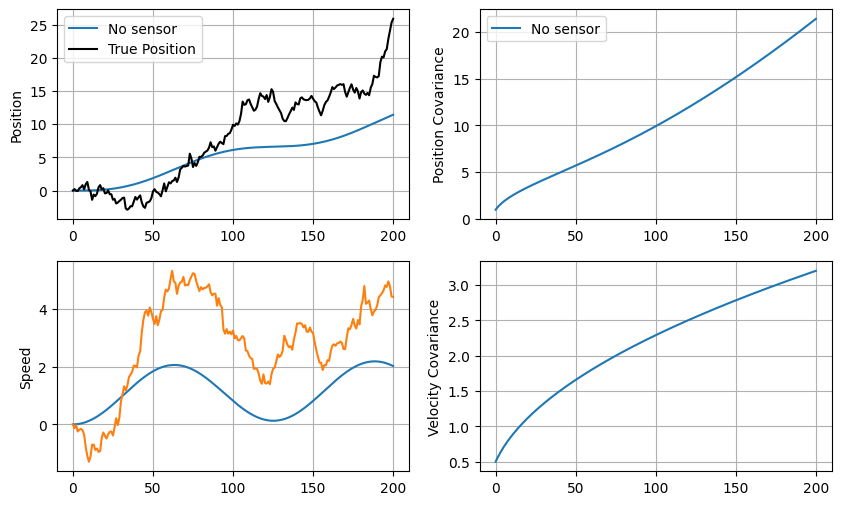

In [18]:

car = StraightLineCar(init_state, 1/f_control)
lkf_no_sensor = LinearControlEstimator(init_belief, car.A, car.B, car.motion_q)

simulate_car(car, inputs, lkf_no_sensor)

car_states = np.array(car.true_states)[:, :, 0]
print(f"Mean Error (No Sensor): {np.mean(np.abs(lkf_no_sensor.get_estimated_states() - car_states)):.3f}")

plot_linear_fusion(car, lkf_no_sensor, "No sensor")


It is clear that using only the control updates results in poor performance since the speed and position estimates drift a lot from the true values. The right hand graphs show how the covariances increase monotonically over time.

Therefore, we now introduce using linear sensors to improve the estimate.
We define a general linear sensor class that can be given, C and R matrices, a measurement frequency and a name for convenience.


In [19]:
class LinearSensor:
    def __init__(self, name, C, R, frequency) -> None:
        self.name = name
        self.C = C
        self.R = R
        self.dt = 1/frequency

    def measure(self, state, t):
        if (t+ 0.001 ) %self.dt< 1/20: 
            measurement =  self.C.dot(state) + np.random.multivariate_normal(np.zeros(self.R.shape[0]), self.R)
        else: measurement = None
        return measurement
    


The first sensor we add is a GPS that provides position updates. The GPS operates with an update frequency of 1 Hz and has a covariance matrix of $R=\text{diag}([0.1^2])$.

Your task is now to extend the Linear Kalman Filter given above to enable the measurement update. 

HINT: use the same equations from the Linear Kalman Filter

In [20]:
class LinearSensorFusion(LinearControlEstimator):
    def __init__(self, init_belief, A, B, Q, sensor_list=[]):
        super().__init__(init_belief, A, B, Q)

        self.sensors = sensor_list
        self.sensor_index = {sensor_list[i].name: i for i in range(len(sensor_list))}
    
    def measurement_update(self, y):
        for m in y.keys():
            if y[m] is None: continue 
            if not m in self.sensor_index.keys(): continue
            C = self.sensors[self.sensor_index[m]].C
            R = self.sensors[self.sensor_index[m]].R

            # WRITE CODE HERE
            mean = self.beliefs[-1].get_mean()
            cov = self.beliefs[-1].get_covariance()
            L = cov.dot(C.T).dot(np.linalg.inv(C.dot(cov).dot(C.T)+R))
            mean_ = mean + L.dot(y[m]-C.dot(mean))
            cov_ = (np.eye(mean.size)-L.dot(C)).dot(cov)
            self.beliefs[-1] = Gaussian(mean_, cov_)

Mean Error (No Sensor): 2.169


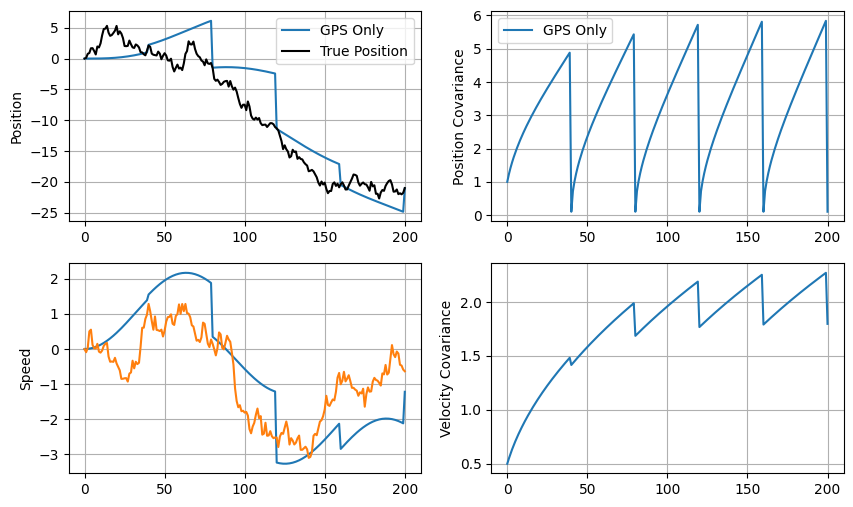

In [21]:

gps = LinearSensor("GPS", np.array([[1, 0]]), np.diag([0.1**2]), f_gps)
car = StraightLineCar(init_state, 1/f_control, [gps])
lkf_gps = LinearSensorFusion(init_belief, car.A, car.B, car.motion_q, [gps])

simulate_car(car, inputs, lkf_gps)

car_states = np.array(car.true_states)[:, :, 0]
print(f"Mean Error (No Sensor): {np.mean(np.abs(lkf_gps.get_estimated_states() - car_states)):.3f}")
cov = lkf_gps.get_estimated_states()
covariances = lkf_gps.get_estimated_covariances()
plot_linear_fusion(car, lkf_gps, "GPS Only")

The above example clearly shows the role of the GPS in providing low-frequency, high-accuracy position updates. The position covariance shows sharp dips after each update.

Another kind of sensor that is commonly used are IMUs that provide high-frequency speed updates. Below is driver code that shows the role of an IMU.

Mean Error (No Sensor): 1.103


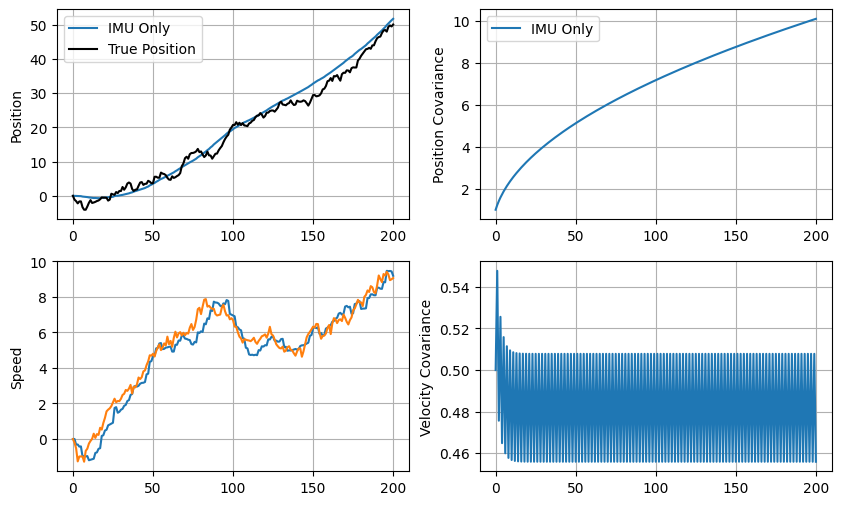

In [22]:
imu = LinearSensor("IMU", np.array([[0, 1]]), np.diag([0.8**2]), f_imu)
car = StraightLineCar(init_state, 1/f_control, [imu])
lkf_imu = LinearSensorFusion(init_belief, car.A, car.B, car.motion_q, [imu])

simulate_car(car, inputs, lkf_imu)

car_states = np.array(car.true_states)[:, :, 0]
print(f"Mean Error (No Sensor): {np.mean(np.abs(lkf_imu.get_estimated_states() - car_states)):.3f}")
plot_linear_fusion(car, lkf_imu, "IMU Only")

The above image shows that the IMU provides high-frequency speed information to the vehicle. While this improves the speed estimation significantly, the position estimate is still subject to drift over time.

To combat this, complementary sensors providing high and low frequency information are combined.
The code below shows how each of the three previous combinations compare to using a full fusion approach. 

Mean Error (No Sensor): 5.059
Mean Error (IMU Only): 3.357
Mean Error (GPS Only): 1.615
Mean Error (Full Fusion): 1.265


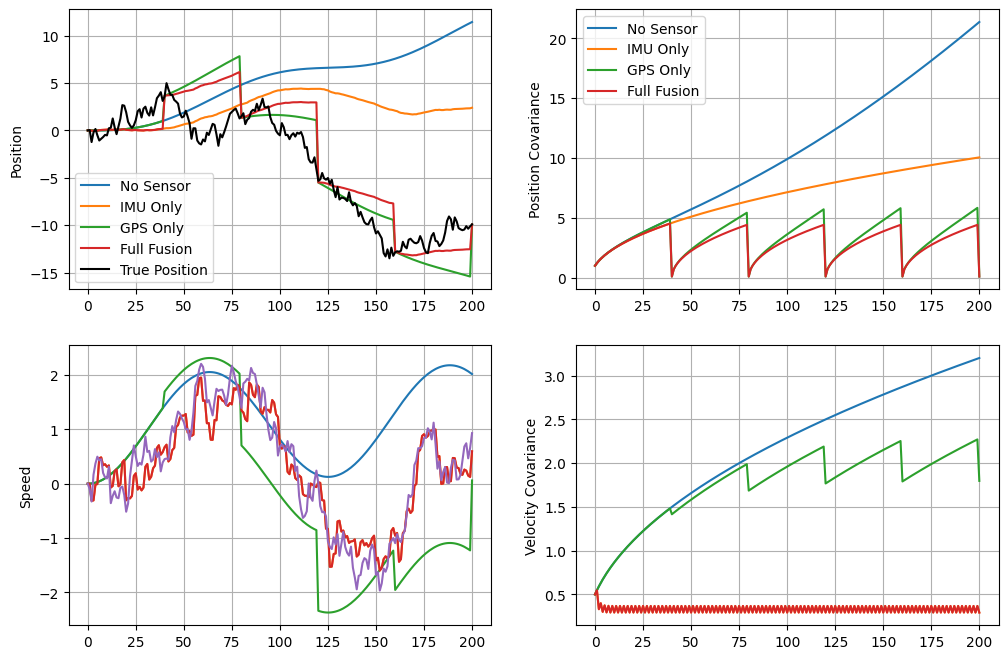

In [23]:
def simulate_car_multiple(car, inputs, filter_list):
    for t in range(simulation_time * f_control):
        car.move(inputs[t])
        for estimator in filter_list: 
            estimator.control_update(inputs[t])

        measurement = car.measure()
        for estimator in filter_list: 
            estimator.measurement_update(measurement)

gps = LinearSensor("GPS", np.array([[1, 0]]), np.diag([0.1**2]), f_gps)
imu = LinearSensor("IMU", np.array([[0, 1]]), np.diag([0.4**2]), f_imu)
car = StraightLineCar(init_state, 1/f_control, [imu, gps])

lkf_no_sensor = LinearSensorFusion(init_belief, car.A, car.B, car.motion_q)
lkf_imu_only = LinearSensorFusion(init_belief, car.A, car.B, car.motion_q, [imu])
lkf_gps_only = LinearSensorFusion(init_belief, car.A, car.B, car.motion_q, [gps])
lkf_full_fusion = LinearSensorFusion(init_belief, car.A, car.B, car.motion_q, [imu, gps])

filter_list = [lkf_no_sensor, lkf_imu_only, lkf_gps_only, lkf_full_fusion]
labels = ["No Sensor", "IMU Only", "GPS Only", "Full Fusion"]
simulate_car_multiple(car, inputs, filter_list)

car_states = np.array(car.true_states)[:, :, 0]
for i in range(len(filter_list)):
    print(f"Mean Error ({labels[i]}): {np.mean(np.abs(filter_list[i].get_estimated_states() - car_states)):.3f}")

plot_estimation_comparison(car, filter_list, labels, "comparison")


<h3 style="margin-bottom:1em;border-bottom:solid 3px #61223B">2. Non-linear Sensor Fusion</h3>

We are now going to extend the principles used in linear sensor fusion to non-linear vehicles.
We use the same rover that was used in Assignment 2, with the dynamics:
$$\begin{bmatrix}
x_k \\
y _k\\
\theta_k 
\end{bmatrix}=\begin{bmatrix}
x_{k-1}+T_s v_{k-1}\cos(\theta_{k-1}) \\
y_{k-1}+T_s v_{k-1}\sin(\theta_{k-1}) \\
\theta_{k-1} + T_s v_{k-1}\frac{\phi_{k-1}}{d} \\
\end{bmatrix}+\mathbf{w}_{k}$$

Two sensors are used to estimate the rovers location, a GPS that provides low-frequency position information, and a magnetometer that provides high-frequency estimates of the heading.

The task is to extend the previous linear sensor fusion algorithm to use the non-linear vehicle model.



In [24]:
from MultiSensorRover import MultiSensorRobot

simulation_time = 6 # seconds
f_control = 10 # seconds
f_mag = 5 # seconds
f_gps = 1 # seconds



In [25]:

class NonLinearSensorFusion:
    def __init__(self, init_belief, f, F_k, Q, name, sensor_list=[]):
        self.name = name
        self.beliefs = [init_belief]
        self.prior = None
        self.f = f
        self.F_k = F_k
        self.Q = Q

        self.sensors = sensor_list
        self.sensor_index = {sensor_list[i].name: i for i in range(len(sensor_list))}

    def add_sensor(self, sensor):
        self.sensors.append(sensor)
        self.sensor_index[sensor.name] = len(self.sensors)-1

    def control_update(self, u):
        mean = self.beliefs[-1].get_mean()
        cov = self.beliefs[-1].get_covariance()
        mean_ = self.f(mean, u)
        F = self.F_k(mean, u)
        cov_ = F.dot(cov).dot(F.T) + self.Q
        prior = Gaussian(mean_, cov_)
        self.beliefs.append(prior)

    def measurement_update(self, y):
        for m in y.keys():
            if y[m] is None: continue
            if not m in self.sensor_index.keys(): continue
            idx  = self.sensor_index[m]
            C = self.sensors[idx].C
            R = self.sensors[idx].R
            measurement = y[m]

            mean = self.beliefs[-1].get_mean()
            cov = self.beliefs[-1].get_covariance()
            L = cov.dot(C.T).dot(np.linalg.inv(C.dot(cov).dot(C.T)+R))
            mean_ = mean + L.dot(measurement-C.dot(mean))
            cov_ = (np.eye(mean.size)-L.dot(C)).dot(cov)
            self.beliefs[-1] = Gaussian(mean_, cov_)

    def get_estimated_states(self):
        states = [belief.get_mean() for belief in self.beliefs]
        return np.array(states)
    
    def get_estimated_covariances(self):
        covariances = [belief.get_covariance() for belief in self.beliefs]
        return np.array(covariances)
    

Mean Error (No Sensor): 3.448
Mean Error (Mag only): 1.795
Mean Error (GPS only): 0.576
Mean Error (Full fusion): 0.466


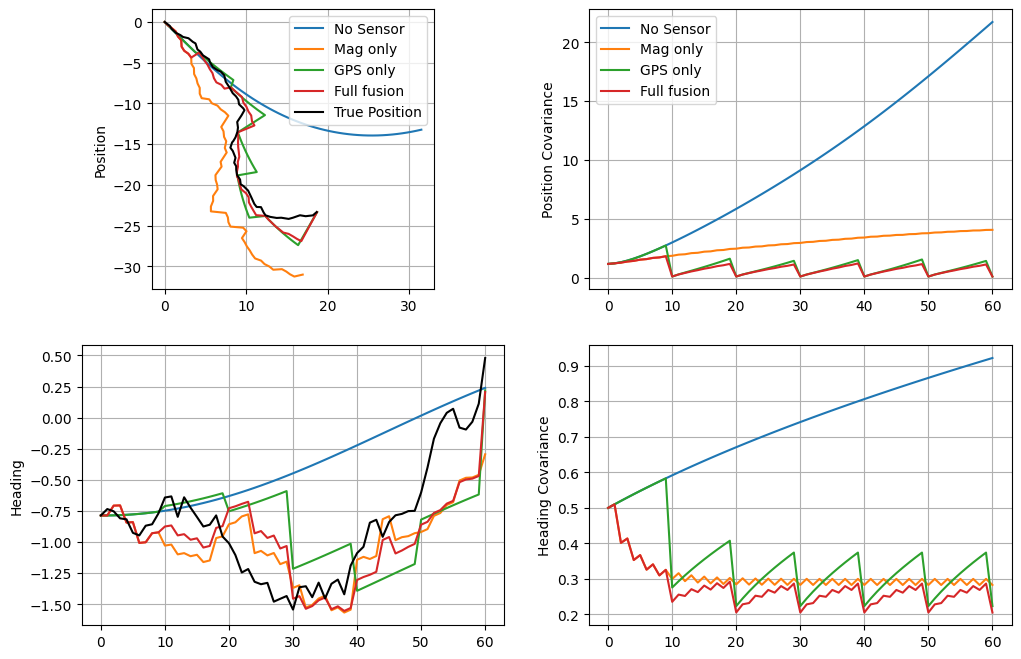

In [28]:

np.random.seed(100)
Q = np.diag([0.2**2, 0.2**2, 0.1**2])
init_state = np.array([0,0,-np.pi/4])
gps = LinearSensor("GPS", np.array([[1, 0, 0], [0, 1, 0]]), np.diag([0.1**2, 0.1**2]), f_gps)
mag = LinearSensor("Mag", np.array([[0, 0, 1]]), np.diag([0.4]), f_mag)
car = MultiSensorRobot(init_state, Q, 1/f_control, [gps, mag])
init_belief = Gaussian(init_state, np.diag([1**2, 1**2, 0.5**2]))

ekf_no_sensor = NonLinearSensorFusion(init_belief, car.f, car.F_k, Q, "No Sensor")
ekf_mag_only = NonLinearSensorFusion(init_belief, car.f, car.F_k, Q, "Mag only", [mag])
ekf_gps_only = NonLinearSensorFusion(init_belief, car.f, car.F_k, Q, "GPS only", [gps])
ekf_full_fusion = NonLinearSensorFusion(init_belief, car.f, car.F_k, Q, "Full fusion", [gps, mag])
estimator_list = [ekf_no_sensor, ekf_mag_only, ekf_gps_only, ekf_full_fusion]

controls = np.sin(np.linspace(0, simulation_time, simulation_time*f_control) * 0.35)  *0.04

simulate_car_multiple(car, controls, estimator_list)

car_states = np.array(car.true_states)
for estimator in estimator_list:
    print(f"Mean Error ({estimator.name}): {np.mean(np.abs(estimator.get_estimated_states() - car_states)):.3f}")

plot_2D_comparison(estimator_list, car)


